<a href="https://colab.research.google.com/github/smitha-nair/AIDL-case-study/blob/main/abcd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing necessary libraries
import pandas as pd
!pip install gradio
import gradio as gr
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np
!pip install lazypredict
import matplotlib.pyplot as plt

#1. Data gathering

In [ ]:
# Load the dataset
df = pd.read_csv("Raw Data Pfizer.csv")
df.head() #displaying the 1st 5 records

,Patient_ID,Age,Gender,Ethnicity,Medical_History,Genomic_Profile,Trial_ID,Drug_Name,Trial_Phase,Start_Date,...,Side_Effects,Duration_of_Treatment,Success_Indicator,Gene_Name,Mutation_Status,Expression_Level,Biomarker_Level,Efficacy_Score,Survival_Rate,Progression_Free_Survival
0,P001,22,Male,African American,Heart Disease,NaN,T011,DrugC,Phase IV,9/16/2023,...,Headache,95,1,BRCA2,Positive,3.79,3.14,3.80,20.60,14.60
1,P002,61,Female,Other,Diabetes,HER2 Mutation,T014,DrugC,Phase I,11/4/2022,...,Headache,90,0,HER2,Negative,1.65,4.64,8.40,23.10,15.30
2,P003,60,Female,Other,Heart Disease,TP53 Mutation,T008,DrugA,Phase I,5/6/2022,...,Fatigue,64,1,HER2,Positive,3.45,2.67,9.40,21.60,3.80
3,P004,76,Other,Other,NaN,EGFR Mutation,T016,DrugB,Phase II,2/17/2023,...,Dizziness,159,1,BRCA2,Positive,1.11,2.51,8.30,23.80,5.60
4,P005,39,Female,Other,Asthma,BRCA2 Mutation,T019,DrugD,Phase I,8/26/2023,...,Dizziness,44,0,EGFR,Negative,3.38,2.52,9.70,21.20,17.30


#2. Data cleaning

2.1 Checking for duplicate rows

In [ ]:
df.duplicated().sum()

0

2.2 Handling Missing data, if any

In [ ]:
#Checking for missing data
df.isnull().sum()

,0
Patient_ID,0
Age,0
Gender,0
Ethnicity,0
Medical_History,182
Genomic_Profile,487
Trial_ID,0
Drug_Name,0
Trial_Phase,0
Start_Date,0


2.2.1. ⚕Dropping rows with missing values

In [ ]:
# Drop rows with missing values
df.dropna(inplace=True)

2.2.2 ⚕Dropping rows with data imputation

In [ ]:
from sklearn.impute import SimpleImputer

# Create a SimpleImputer object with 'most_frequent' strategy
imputer = SimpleImputer(strategy='most_frequent')

# Select the columns for imputation
categorical_features = ['Medical_History', 'Genomic_Profile', 'Adverse_Events']

# Impute missing values in the specified columns
for feature in categorical_features:
    feature_data = df[[feature]]
    # Reshape to a 1D array
    df[feature] = imputer.fit_transform(feature_data).ravel() # This is the change

In [ ]:
df_original = df.copy()   # Required for future use

2.3 Handling irrelevant data

In [ ]:
# Drop Patient_ID
df.drop(columns=["Patient_ID"], inplace=True)

# Convert date columns to datetime
df["Start_Date"] = pd.to_datetime(df["Start_Date"])
df["End_Date"] = pd.to_datetime(df["End_Date"])

# Create Trial Duration feature
df["Trial_Duration"] = (df["End_Date"] - df["Start_Date"]).dt.days

#Trial Duration is a substitute for start and end dates; so dropping
df.drop(columns=["Start_Date", "End_Date"], inplace=True)

#3. Data Transformation

3.1 Label Encoding

In [ ]:
# Encode categorical features
categorical_columns = df.select_dtypes(include=["object"]).columns.tolist()
label_encoders = {}
categorical_options = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    categorical_options[col] = list(le.classes_)

3.2 Normalization

In [ ]:
# Normalize numerical features
numerical_columns = df.select_dtypes(include=["number"]).columns.tolist()
numerical_columns.remove("Success_Indicator")  # Ensure Success_Indicator is excluded
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

#4. Data splitting for training and testing

4.1 Prepare Feature variables and Target variable

In [ ]:
# Split dataset into features and target variable
features = df.drop(columns=["Success_Indicator"])
target = df[["Success_Indicator"]]

4.2 Splitting by using train_test_split

In [ ]:
# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.3, random_state=False)

4.3 Checking the dimension of training and testing data

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(221, 23)
(95, 23)
(221, 1)
(95, 1)


4.4 Checking if the data is balanced

In [ ]:
Y_train['Success_Indicator'].value_counts()

,count
Success_Indicator,
0,150
1,71


4.5 Handling imbalanced dataset using SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
#Synthetic Minority Over-sampling Technique.
# a technique used in machine learning to address class imbalance in datasets
smote = SMOTE(random_state=42)
X_train, Y_train = smote.fit_resample(X_train, Y_train)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
#SMOTE increased your training data by creating new,
#synthetic samples of the minority class, bringing the total number # of samples to be equal for both classes.
#This helps to balance the dataset and improve the performance of machine learning models,
#especially in cases where the original dataset is imbalanced

(300, 23)
(95, 23)
(300, 1)
(95, 1)


#5. Training machine learning models

In [ ]:
from lazypredict.Supervised import LazyClassifier

# Initialize LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Fit LazyClassifier with our split data
models, predictions = clf.fit(X_train, X_test, Y_train, Y_test)

# Display the performance of all models
print(models)

100%|██████████| 32/32 [00:03<00:00, 10.34it/s]


[LightGBM] [Info] Number of positive: 150, number of negative: 150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 300, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

#6. Choosing the best machine learning model to build the prediction model

In [ ]:
#Chose decision tree classifier since it gives 100% acc in least time

from sklearn.tree import DecisionTreeClassifier
# Create Decision Tree classifer object
model = DecisionTreeClassifier()

# Train Decision Tree Classifer
model = model.fit(X_train, Y_train)

#Predict the response for test dataset
Y_pred = model.predict(X_test)

#7. Evaluation

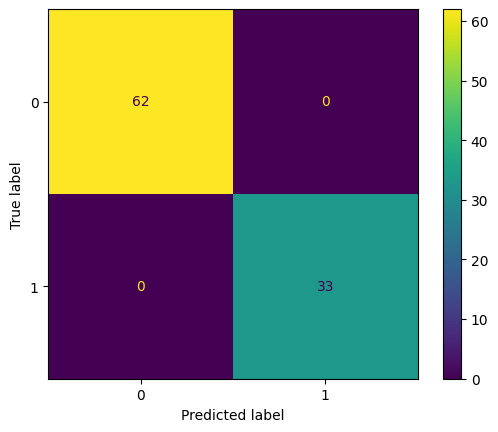

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Generate the confusion matrix
cm = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test)

# Display the plot
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Assuming you already have Y_test and Y_pred
report = classification_report(Y_test, Y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        33

    accuracy                           1.00        95
   macro avg       1.00      1.00      1.00        95
weighted avg       1.00      1.00      1.00        95



#8. Deployment

In [ ]:
# Save model, scaler, and encoders
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
with open("label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

In [ ]:
# Load saved models
def load_models():
    with open("model.pkl", "rb") as f:
        model = pickle.load(f)
    with open("scaler.pkl", "rb") as f:
        scaler = pickle.load(f)
    with open("label_encoders.pkl", "rb") as f:
        label_encoders = pickle.load(f)
    return model, scaler, label_encoders

In [ ]:
# Function to predict Success Indicator
def predict_success(start_date, end_date, *inputs):
    model, scaler, label_encoders = load_models()
    try:
        trial_duration = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
    except:
        return "Invalid Date Format"

    inputs = list(inputs)  # Remove original date columns
    inputs.append(trial_duration)

    input_data = pd.DataFrame([inputs], columns=X.columns)

    for col in categorical_columns:
        if col in input_data.columns and input_data[col][0] in categorical_options[col]:
            input_data[col] = label_encoders[col].transform([input_data[col][0]])[0]
        else:
            return f"Invalid category for {col}"

    input_data[numerical_columns] = scaler.transform(input_data[numerical_columns])
    prediction = model.predict(input_data)[0]
    return "WoW - Success" if prediction == 1 else "Oh - Failure"

In [ ]:
# Define Gradio Interface
inputs = [
    gr.Textbox(label="Start Date (YYYY-MM-DD)"),
    gr.Textbox(label="End Date (YYYY-MM-DD)")
]

X = features

for col in X.columns:
    if col != "Trial_Duration":  # Excluding Trial Duration from manual input (calculated separately)
        if col in categorical_options:
            inputs.append(gr.Dropdown(choices=categorical_options[col], label=col))
        else:
            inputs.append(gr.Number(label=col))

iface = gr.Interface(fn=predict_success, inputs=inputs, outputs="text", title="PrecisionCapsule.AI Predictor")

# Launch Gradio Interface
if __name__ == "__main__":
    iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b7b93cd12c6f7d8a8d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


##Testing data to check the correctness of output

In [ ]:
#Retrieving the indices of test data#
X_train, X_test, Y_train, Y_test, train_indices, test_indices  = train_test_split(
    features, target, range(len(features)), test_size=0.3, random_state=False
)

# Print or use the test_indices
print("Indices of test data:", test_indices)

Indices of test data: [134, 287, 55, 254, 276, 81, 116, 124, 311, 56, 222, 246, 15, 59, 259, 208, 164, 146, 153, 74, 26, 159, 199, 249, 247, 253, 133, 22, 60, 267, 7, 21, 171, 52, 12, 278, 97, 296, 173, 263, 308, 65, 223, 170, 260, 136, 220, 306, 198, 63, 157, 234, 219, 17, 252, 8, 145, 262, 64, 66, 103, 209, 214, 129, 5, 33, 284, 34, 120, 108, 315, 45, 152, 101, 122, 135, 132, 191, 90, 237, 168, 217, 73, 309, 300, 144, 140, 29, 92, 20, 46, 179, 258, 255, 89]


In [ ]:
df_original.iloc[134]   #PredictorCapsulr.AI should output as Success_Indicator is 0 (Failure)

,429
Patient_ID,P430
Age,57
Gender,Other
Ethnicity,Asian
Medical_History,Diabetes
Genomic_Profile,BRCA1 Mutation
Trial_ID,T006
Drug_Name,DrugB
Trial_Phase,Phase III
Start_Date,3/1/2022
